In [2]:
import pandas as pd
import numpy as np
import holidays

In [3]:
d_categories = pd.read_csv('./readonly/final_project_data/item_categories.csv')
d_items = pd.read_csv('./readonly/final_project_data/items.csv')
f_train = pd.read_csv('./readonly/final_project_data/sales_train.csv')
d_shops = pd.read_csv('./readonly/final_project_data/shops.csv')
d_test = pd.read_csv('./readonly/final_project_data/test.csv')

In [4]:
print('d_categories:', d_categories.shape, d_categories.columns)
print('d_items:', d_items.shape, d_items.columns)
print('f_train:', f_train.shape, f_train.columns)
print('d_shops:', d_shops.shape, d_shops.columns)
print('d_test:', d_test.shape, d_test.columns)

d_categories: (84, 2) Index(['item_category_name', 'item_category_id'], dtype='object')
d_items: (22170, 3) Index(['item_name', 'item_id', 'item_category_id'], dtype='object')
f_train: (2935849, 6) Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')
d_shops: (60, 2) Index(['shop_name', 'shop_id'], dtype='object')
d_test: (214200, 3) Index(['ID', 'shop_id', 'item_id'], dtype='object')


In [5]:
train = pd.merge(f_train, d_items, on = 'item_id').drop(['item_name', 'date_block_num'], axis=1)
train.date = pd.to_datetime(train.date, format='%d.%m.%Y')
train['sales'] = train.item_cnt_day * train.item_price # sales amount of item that day in that shop

In [6]:
november_dates =pd.date_range(start = '2015-11-1',end='2015-11-30', freq='D', name='date').to_series()

In [26]:
test = pd.merge(d_test,november_dates, how = 'cross').drop('ID', axis = 1)
test = pd.merge(test, d_items, on = 'item_id').drop('item_name', axis=1)

In [31]:
train.groupby(['date','item_id','shop_id']).mean().sort_values('date', ascending=False)

item_price  item_cnt_day  item_category_id  \
date       item_id shop_id                                               
2015-10-31 22167   42           299.00           1.0              49.0   
           7057    55          3599.00           1.0              31.0   
           6728    35           932.66           1.0              23.0   
                   14          1399.00           1.0              23.0   
           6727    47          1399.00           1.0              19.0   
...                                ...           ...               ...   
2013-01-01 13901   27           299.00           1.0              55.0   
                   28           299.00           2.0              55.0   
           13927   7            149.00           1.0              40.0   
           13959   15           149.00           1.0              40.0   
           32      27           349.00           1.0              40.0   

                              sales  ends_with_9  ends_with_49  ends_with_99  \
date       item_id shop_id                                                     
2015-10-31 22167   42        299.00          1.0           0.0           0.0   
           7057    55       3599.00          1.0           0.0           0.0   
           6728    35        932.66          0.0           0.0           0.0   
                   14       1399.00          1.0           0.0           0.0   
           6727    47       1399.00          1.0           0.0           0.0   
...                             ...          ...           ...           ...   
2013-01-01 13901   27        299.00          1.0           0.0           0.0   
                   28        598.00          1.0           0.0           0.0   
           13927   7         149.00          1.0           1.0           0.0   
           13959   15        149.00          1.0           1.0           0.0   
           32      27        349.00          1.0           1.0           0.0   

                            item_price_below_q99  item_price_below_q95  \
date       item_id shop_id                                               
2015-10-31 22167   42                        1.0                   1.0   
           7057    55                        1.0                   0.0   
           6728    35                        1.0                   1.0   
                   14                        1.0                   1.0   
           6727    47                        1.0                   1.0   
...                                          ...                   ...   
2013-01-01 13901   27                        1.0                   1.0   
                   28                        1.0                   1.0   
           13927   7                         1.0                   1.0   
           13959   15                        1.0                   1.0   
           32      27                        1.0                   1.0   

                            item_price_below_q50  category_top5_price  \
date       item_id shop_id                                              
2015-10-31 22167   42                        1.0                  0.0   
           7057    55                        0.0                  0.0   
           6728    35                        0.0                  0.0   
                   14                        0.0                  0.0   
           6727    47                        0.0                  0.0   
...                                          ...                  ...   
2013-01-01 13901   27                        1.0                  0.0   
                   28                        1.0                  0.0   
           13927   7                         1.0                  0.0   
           13959   15                        1.0                  0.0   
           32      27                        1.0                  0.0   

                            category_top10_price  category_top20_price  \
date       item_id shop_id           

In [36]:
train.groupby(['date','item_id','shop_id']).mean().sort_values('date', ascending=False).query('date >= "2015-10-01"').idxmax(axis=1)

date        item_id  shop_id
2015-10-31  22167    42         item_price
            7057     55         item_price
            6728     35         item_price
                     14         item_price
            6727     47         item_price
                                   ...    
2015-10-01  15069    4               sales
            15067    59         item_price
            15068    42         item_price
            15069    3          item_price
                     2          item_price
Length: 53513, dtype: object

In [41]:
df = train.groupby(['date','shop_id','item_id']).mean().sort_values(['date','shop_id'], ascending=False)

In [43]:
train.groupby(['date','shop_id','item_id']).max()

item_price  item_cnt_day  item_category_id  \
date       shop_id item_id                                               
2013-01-01 2       991            99.0           1.0                67   
                   1472         2599.0           1.0                23   
                   1905          249.0           1.0                30   
                   2920          599.0           2.0                21   
                   3320         1999.0           1.0                19   
...                                ...           ...               ...   
2015-10-31 59      20730         499.0           1.0                72   
                   20866         699.0           1.0                72   
                   20949           5.0           1.0                71   
                   21369         169.0           1.0                40   
                   21449         449.0           1.0                40   

                             sales  ends_with_9  ends_with_49  ends_with_99  \
date       shop_id item_id                                                    
2013-01-01 2       991        99.0         True         False         False   
                   1472     2599.0         True         False         False   
                   1905      249.0         True          True         False   
                   2920     1198.0         True         False         False   
                   3320     1999.0         True         False         False   
...                            ...          ...           ...           ...   
2015-10-31 59      20730     499.0         True         False         False   
                   20866     699.0         True         False         False   
                   20949       5.0        False         False         False   
                   21369     169.0         True         False         False   
                   21449     449.0         True          True         False   

                            item_price_below_q99  item_price_below_q95  \
date       shop_id item_id                                               
2013-01-01 2       991                      True                  True   
                   1472                     True                  True   
                   1905                     True                  True   
                   2920                     True                  True   
                   3320                     True                  True   
...                                          ...                   ...   
2015-10-31 59      20730                    True                  True   
                   20866                    True                  True   
                   20949                    True                  True   
                   21369                    True                  True   
                   21449                    True                  True   

                            item_price_below_q50  category_top5_price  \
date       shop_id item_id                                              
2013-01-01 2       991                      True                False   
                   1472                    False                False   
                   1905                     True                False   
                   2920                    False                False   
                   3320                    False                False   
...                                          ...                  ...   
2015-10-31 59      20730                   False                False   
                   20866                   False                False   
                   20949                    True                False   
                   21369                    True                False   
                   21449                   False                False   

                            category_top10_price  category_top20_price  \
date       shop_id item_id                        

In [48]:
shopid = 2
itemid = 3320
train[(train.shop_id == shopid) & (train.item_id == itemid)].sort_values('date', ascending=False).head(1).item_price.value

AttributeError: 'Series' object has no attribute 'value'

In [9]:
train.isnull().sum(axis=1).head(15)
train.isnull().sum(axis=0).head(15)

date                0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
sales               0
dtype: int64

No NaNs

In [10]:
train.nunique(dropna=False)

date                 1034
shop_id                60
item_id             21807
item_price          19993
item_cnt_day          198
item_category_id       84
sales               24771
dtype: int64

1034 days, 60 shops, 22k items, 84 item categories

shop_id
54    1.419397e+08
42    1.519170e+08
28    1.597463e+08
25    2.164806e+08
31    2.352170e+08
Name: sales, dtype: float64

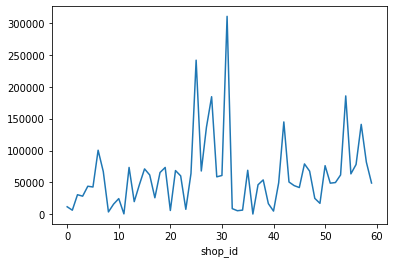

In [11]:
train.groupby('shop_id').item_cnt_day.sum().plot()
train.groupby('shop_id').item_cnt_day.sum().sort_values().tail()

#train.groupby('shop_id').sales.sum().plot()
train.groupby('shop_id').sales.sum().sort_values().tail()

shop_id 31,25 have the most net transactions, and also the highest sales and revenue

shop_id
42    1.326591
55    1.823118
12    2.117888
20    3.276786
9     4.229805
Name: item_cnt_day, dtype: float64

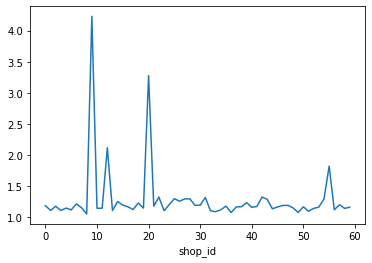

In [12]:
train.groupby('shop_id').item_cnt_day.mean().plot()
train.groupby('shop_id').item_cnt_day.mean().sort_values().tail()

shop_id 9,20,12,55 have the most items sold per day

In [13]:
train.item_price.value_counts()

299.00     291352
399.00     242603
149.00     218432
199.00     184044
349.00     101461
            ...  
345.57          1
318.71          1
318.09          1
340.49          1
4040.00         1
Name: item_price, Length: 19993, dtype: int64

A lot of item prices end with 9. Use this fact as a feature.

In [14]:
def ends_with_9(x):
    if str(x)[-3] == '9':
        return True
    else:
        return False

def ends_with_49(x):
    if str(x)[-4:][0:2] == '49':
        return True
    else:
        return False

def ends_with_99(x):
    if str(x)[-4:][0:2] == '09':
        return True
    else:
        return False

train['ends_with_9'] = train.item_price.apply(ends_with_9)
train['ends_with_49'] = train.item_price.apply(ends_with_49)
train['ends_with_99'] = train.item_price.apply(ends_with_99)

In [15]:
train.ends_with_9.value_counts()
#train.ends_with_49.value_counts()
#train.ends_with_99.value_counts()

True     2451628
False     484221
Name: ends_with_9, dtype: int64

3196.0

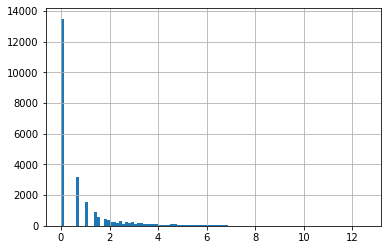

In [16]:
train.sales.value_counts().apply(np.log).hist(bins=100)
train.sales.quantile(q=0.95)

Sales are extremely unevenly distributed, with 50% of sales occurring below 449. Separate items into quantiles.

In [17]:
q_99 = train.item_price.quantile(q=0.99)
q_95 = train.item_price.quantile(q=0.95)
q_50 = train.item_price.quantile(q=0.5)

train['item_price_below_q99'] = train.item_price.apply(lambda x: x <= q_99)
train['item_price_below_q95'] = train.item_price.apply(lambda x: x <= q_95)
train['item_price_below_q50'] = train.item_price.apply(lambda x: x <= q_50)

<AxesSubplot:>

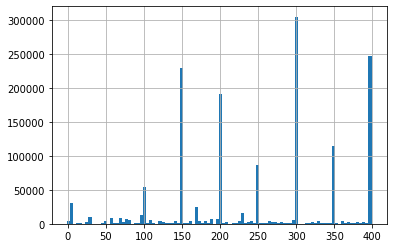

In [18]:
train.item_price[train.item_price_below_q50].hist(bins=100)

Here we also see the behaviour we captured above: almost all item prices end with 49 or 99.

Relationship between item prices and item categories

array([[<AxesSubplot:title={'center':'item_price'}>]], dtype=object)

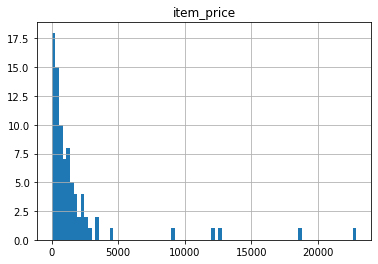

In [19]:
train.groupby('item_category_id').mean().sort_values('item_price')[['item_price']].hist(bins=84)

<AxesSubplot:>

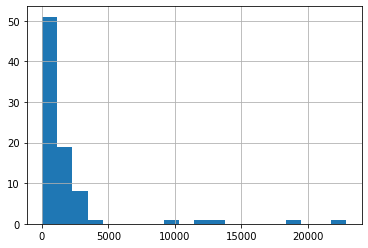

In [20]:
mean_category_price = train.groupby('item_category_id').mean().item_price
mean_category_price.hist(bins=20)

In [21]:
# Top 5 categories by item price
category_top5_price = train.groupby('item_category_id').mean().sort_values('item_price', ascending=False).head(5).index.values
# Top 10 categories by item price
category_top10_price = train.groupby('item_category_id').mean().sort_values('item_price', ascending=False).head(10).index.values
# Top 20 categories by item price
category_top20_price = train.groupby('item_category_id').mean().sort_values('item_price', ascending=False).head(20).index.values

# Top 5 categories by item count
category_top5_cnt = train.groupby('item_category_id').mean().sort_values('item_cnt_day', ascending=False).head(5).index.values
# Top 10 categories by item count
category_top10_cnt = train.groupby('item_category_id').mean().sort_values('item_cnt_day', ascending=False).head(10).index.values
# Top 20 categories by item count
category_top20_cnt = train.groupby('item_category_id').mean().sort_values('item_cnt_day', ascending=False).head(20).index.values




In [22]:
train['category_top5_price'] = train.item_category_id.isin(category_top5_price)
train['category_top10_price'] = train.item_category_id.isin(category_top10_price)
train['category_top20_price'] = train.item_category_id.isin(category_top20_price)

train['category_top5_cnt'] = train.item_category_id.isin(category_top5_cnt)
train['category_top10_cnt'] = train.item_category_id.isin(category_top10_cnt)
train['category_top20_cnt'] = train.item_category_id.isin(category_top20_cnt)

In [23]:
train['weekday'] = train.date.apply(lambda x: x.weekday())
russian_holidays = holidays.RU()
train['holiday'] = train.date.isin(russian_holidays)

In [24]:
train

,date,shop_id,item_id,item_price,item_cnt_day,item_category_id,sales,ends_with_9,ends_with_49,ends_with_99,...,item_price_below_q95,item_price_below_q50,category_top5_price,category_top10_price,category_top20_price,category_top5_cnt,category_top10_cnt,category_top20_cnt,weekday,holiday
0,2013-01-02,59,22154,999.0,1.0,37,999.0,True,False,False,...,True,False,False,False,False,False,False,False,2,False
1,2013-01-23,24,22154,999.0,1.0,37,999.0,True,False,False,...,True,False,False,False,False,False,False,False,2,False
2,2013-01-20,27,22154,999.0,1.0,37,999.0,True,False,False,...,True,False,False,False,False,False,False,False,6,False
3,2013-01-02,25,22154,999.0,1.0,37,999.0,True,False,False,...,True,False,False,False,False,False,False,False,2,False
4,2013-01-03,25,22154,999.0,1.0,37,999.0,True,False,False,...,True,False,False,False,False,False,False,False,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-17,25,8428,249.0,1.0,40,249.0,True,True,False,...,True,True,False,False,False,False,False,False,5,False
2935845,2015-10-01,25,7903,12198.0,1.0,15,12198.0,False,False,False,...,False,False,True,True,True,False,False,False,3,False
2935846,2015-10-29,25,7610,2890.0,1.0,64,2890.0,False,False,False,...,False,False,False,False,False,False,False,False,3,False
2935847,2015-10-22,25,7635,2100.0,1.0,64,2100.0,False,False,False,...,True,False,False,False,False,False,False,False,3,False
